## Aim of the Notebook 

* Given a Query, Search for related papers. 
* Papers are searched using their Title and Abstract 
* Once potential papers are searched, find specific lines in the Papers talking about the given query.
* Using BM25 Algorithm, used for creating search engines and also to search lines in Potential papers.  
  Read about the algorithm: [https://en.wikipedia.org/wiki/Okapi_BM25]
* FINAL OUTCOME: Find the right papers for a given query, and then highlight/find right lines in the paper.
* Discliamer: Data Analysis / Visualization is not done extensively. THE FOCUS IS ON CREATING ALGORITHM WHICH AND FIND RIGHT LINES IN THE PAPERS DEALING WITH THE GIVEN QUERY.

    

### Download the Dependencies

In [1]:
!pip install rank_bm25 nltk
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_md-0.2.4.tar.gz

  Created wheel for rank-bm25: filename=rank_bm25-0.2-py3-none-any.whl size=4161 sha256=c8901869c5c617387674ba9fd57b40e60311259720e5a65e995e96c9184b004d
  Stored in directory: /root/.cache/pip/wheels/82/a9/a2/33d3c389435f63f6fa490ef91417c997ccc4e7db75f5a7b2f8
Successfully built rank-bm25
     |████████████████████████████████| 3.0 MB 29.6 MB/s 
     |████████████████████████████████| 12.9 MB 10.7 MB/s 
     |████████████████████████████████| 6.1 MB 43.4 MB/s 
     |████████████████████████████████| 46 kB 3.1 MB/s 
  Created wheel for scispacy: filename=scispacy-0.2.4-py3-none-any.whl size=35203 sha256=c85653512e3d9578bd5e14ce9a0a1b537f9a7a1be706ee3206b9e671b63cfda5
  Stored in directory: /root/.cache/pip/wheels/80/01/69/37a2ab4f9b61773c187d83257ffb31365a5ad57e7779ae5e92
Successfully built scispacy
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompatible.
  Attempting uninstall: botocore
    Found existing installation: botocore 1.15.13


### Import the dependencies

In [2]:
import numpy as np # linear algebra
import os
import json
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import re
import string
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi
import spacy
import  scispacy
from nltk.tokenize import sent_tokenize
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

### Load All Papers (Jsons) in a Dataframe

In [3]:
df = pd.DataFrame(columns=['paper_id', 'title', 'abstract', 'body_text'])
i = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.json')==True:
            dic = json.loads(open(os.path.join(dirname, filename), 'r').read())
            id  = dic['paper_id']
            title = dic['metadata']['title']
            if title.strip()=='':
                title = None
            abstract = dic['abstract']
            abstract_list = []
            for a in abstract:
                t = a['text']
                abstract_list.append(t)
            abstract_string = '\n'.join(abstract_list)
            
            if abstract_string == '':
                abstract_string = None

            body_text = dic['body_text']
            body_texts_list = []
            for text in body_text:
                t = text['text']
                body_texts_list.append(t)
                
            body_text_string = '\n'.join(body_texts_list)
            body_text_string = body_text_string.strip()
            if body_text_string == '':
                body_text_string = None
                
            df.loc[i] = [id, title, abstract_string, body_text_string]
            i+=1
                
            

KeyError: 'abstract'

In [4]:
## Set the paper id as the index
df = df.set_index('paper_id')

In [5]:
print (df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2377 entries, d99acb4e99be7852aa61a688c9fbd38d44b5a252 to 021291da7cf3769e4182317703a95b6c5f7c76f9
Data columns (total 3 columns):
title        2109 non-null object
abstract     1719 non-null object
body_text    2377 non-null object
dtypes: object(3)
memory usage: 74.3+ KB
None


In [6]:
df.describe()

,title,abstract,body_text
count,2109,1719,2377
unique,1880,1584,2229
top,CLINICAL EXPERIMENTAL VACCINE RESEARCH,The basic reproduction number of an infectious...,Coronaviruses are a group of enveloped viruses...
freq,14,3,3


In [7]:
### Remove the null values
df.dropna(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1650 entries, d99acb4e99be7852aa61a688c9fbd38d44b5a252 to c2ad458ccf62686e340e51ea95c439e7c4e2bc29
Data columns (total 3 columns):
title        1650 non-null object
abstract     1650 non-null object
body_text    1650 non-null object
dtypes: object(3)
memory usage: 51.6+ KB


In [9]:
### Create a copy of the dataframe and work on that
df_work = df.copy()

### Preprocessing 

In [10]:
# medium model
import en_core_sci_md
nlp = en_core_sci_md.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 2000000

In [11]:
# New stop words list 
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.',
    'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da',  'dell',  'non', 'si'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [12]:
stop_words = nlp.Defaults.stop_words

In [13]:
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

In [14]:
s = ' i am a good-boy , i (am rishav) ?'
spacy_tokenizer(s)

['good-boy', 'rishav']

In [15]:
df_work['body_text'] = df_work['body_text'].apply(spacy_tokenizer)
df_work['abstract'] = df_work['abstract'].apply(spacy_tokenizer)
df_work['title'] = df_work['title'].apply(spacy_tokenizer)

In [16]:
df_work['body_text'] = df_work['body_text'].apply(lambda x: ' '.join(x))
df_work['abstract'] = df_work['abstract'].apply(lambda x: ' '.join(x))
df_work['title'] = df_work['title'].apply(lambda x: ' '.join(x))


In [17]:
df_work.head()

,title,abstract,body_text
paper_id,,,
d99acb4e99be7852aa61a688c9fbd38d44b5a252,Evaluation Measles Vaccine Virus Vector Delive...,Live attenuate recombinant measle vaccine viru...,Live attenuate virus develope help protect hum...
748d4c57fe1acc8d9d97cf574f7dea5296f9386c,Direct visualization Ebola virus fusion trigge...,Ebola virus EBOV make extensive intricate use ...,occur primarily macropinocytosis-like process ...
76d2990a2663635e195b8a9818f9664872b6d3af,Metagenomic Assay Identification Microbial Pat...,Screening thousand virus pathogenic microorgan...,T-cell leukemia virus type human T-cell leukem...
5407b1aabede9eeed76c59a7b890be9f513712b7,simple safe antibody neutralization assay base...,evaluation immunogenicity Sabin strain base In...,Poliomyelitis cause poliovirus acute infectiou...
c40185936592afcdc0681000e25585dd58f5ef41,EMBO Eur,membrane-spanning cytoplasmic domain CD4 CD8 r...,motif result retrieval soluble ER protein lose...


### Paper to index mapping

In [18]:
paper_ids = df_work.index
id_2_paper = {}
for i, id in enumerate(paper_ids):
    id_2_paper[i] = id


### Let's take title and abstract for paper search

In [19]:
df_work['append_title_abstract'] = df_work['title'] + ' ' + df_work['abstract'] 

### Create a index of the Papers

In [20]:
corpus = df_work['append_title_abstract'].tolist()
tokenized_corpus = [doc.split(" ") for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

### Potential papers which could contain what we want

In [21]:
from IPython.display import display, Markdown

In [22]:
def markdown_print(line):
    print(line)

In [23]:
def suggestPapers(query):
    top_20_papers = []
    query_pre = spacy_tokenizer(query)
    doc_scores = bm25.get_scores(query_pre)
    doc_scores = [(score, ind) for ind, score in enumerate(doc_scores)]
    doc_scores = sorted(doc_scores, reverse = True)
    doc_score_top_20 = doc_scores[:20]
    for d in doc_score_top_20:
        i = d[1]
        top_20_papers.append((paper_ids[i], d[0]))
        
    suggested_papers_dict = {}
    for ele in top_20_papers:
        suggested_papers_dict[ele[0]] = ele[1]
        
    for paper in top_20_papers[:5]:
        markdown_print ("Paper Id: " +paper[0])
        markdown_print("Title: "+df.loc[paper[0]]['title'])
        markdown_print ("-----")
    return top_20_papers, suggested_papers_dict

In [24]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

### Let's find the lines in the Paper talking about the given Query
* Here, we are picking all the top 20 papers and forming a coupus of all pair from them. 
* This will be our corpus where we will be searching our query on.

In [25]:
def create_paper_lines(suggested_papers):
    paper_lines = []
    for paper in suggested_papers:
        text = df.loc[paper[0]]['abstract']
        sentences = [(sent.strip(), paper[0]) for sent in sent_tokenize(text)]
        sentences_2_s = []
        for i in range(0, len(sentences)-1):
            sent1 = sentences[i][0]
            sent2 = sentences[i+1][0]
            sent = sent1 + ' ' + sent2
            sentences_2_s.append((sent, sentences[i][1]))
        paper_lines.extend(sentences_2_s)
    return paper_lines

In [26]:
def create_wordcloud(paper_lines):
    word_cloud_data = []
    for line, id in paper_lines:
        word_cloud_data.append(line)
    show_wordcloud(word_cloud_data)

In [27]:
def create_mapping(paper_lines):
    id_paper_line_paper_id = {}
    for i, tup in enumerate(paper_lines):
        id_paper_line_paper_id[i] = (tup[0], tup[1])
    return id_paper_line_paper_id

def create_paper_lines_index(paper_lines):
    paper_lines_fmtd = []
    for line in paper_lines:
        paper_lines_fmtd.append(" ".join(spacy_tokenizer(line[0])))
    tokenized_paper_lines = [doc.split(" ") for doc in paper_lines_fmtd]
    bm25_task1 = BM25Okapi(tokenized_paper_lines)
    return bm25_task1

In [28]:
def top_lines_suggestor(task, bm25_task1, id_paper_line_paper_id):
    top_50_lines = []
    task1_pre = spacy_tokenizer(task)
    line_scores = bm25_task1.get_scores(task1_pre)
    line_scores = [(score, ind) for ind, score in enumerate(line_scores)]
    line_scores = sorted(line_scores, reverse = True)
    line_scores_top_50 = line_scores[:50]
    for l in line_scores_top_50:
        i = l[1]
        paper_id = id_paper_line_paper_id[i][1]
        actual_line = id_paper_line_paper_id[i][0]
        line_score = l[0]
        paper_score = suggested_papers_dict[paper_id]
        net_score = paper_score * line_score
        top_50_lines.append((actual_line, net_score, paper_id))
    top_ten_sorted = sorted(top_50_lines, key = lambda x: x[1], reverse=True)[:20]
    for line in top_ten_sorted:
        markdown_print ("Paper line: " +line[0])
        markdown_print ("Paper id: " +  line[2])
        markdown_print ("Similarity Score: " + str(line[1]))
        markdown_print ("-----")

### Analysis of Incubation periods and Recovery time

In [29]:
task1 = 'Range of incubation periods for the disease in humans (and how this varies across age and health status) \
and how long individuals are contagious,even after recovery.'
suggested_papers, suggested_papers_dict = suggestPapers(task1)  ### TOP SUGGESTED PAPERS

Paper Id: 7a5d731cd59597da7bcef171af936c0af4d7528c
Title: EPIDEMIC AND CASE INVESTIGATIONS Surveillance operation for the 141st confirmed case of Middle East Respiratory Syndrome coronavirus in response to the patient's prior travel to Jeju Island
-----
Paper Id: d4b843968ab01451c9553576eff63a52ad8ba9a4
Title: Journal Pre-proof Serial interval of novel coronavirus (COVID-19) infections Title: Serial interval of novel coronavirus (COVID-19) infections Authors
-----
Paper Id: e44b1713295bc4efbd758d8886b84fb68c725325
Title: Journal Pre-proof Serial interval of novel coronavirus (COVID-19) infections Title: Serial interval of novel coronavirus (COVID-19) infections Authors
-----
Paper Id: 5b7753b6a659e6afa0a46fe171a372e682b07010
Title: Frequent Asymptomatic Respiratory Syncytial Virus Infections During an Epidemic in a Rural Kenyan Household Cohort
-----
Paper Id: 398bb77199ddb0d4e54efc14a1f1ef4c4ccb312b
Title: Epidemics on networks: Reducing disease transmission using health emergency dec

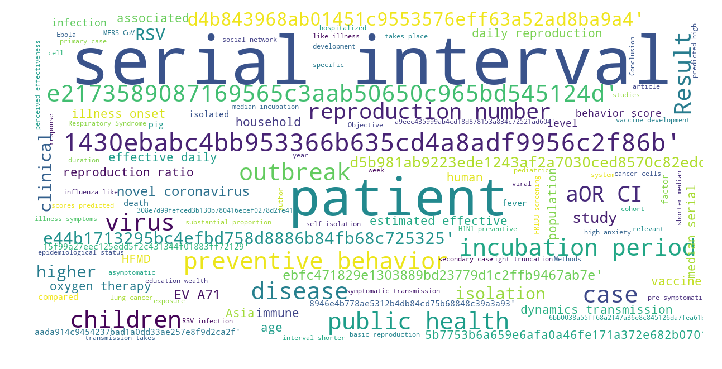

In [30]:
paper_lines = create_paper_lines(suggested_papers)
show_wordcloud(paper_lines)  ### Show the wordcloud for the given topic, what words are prevlant

In [31]:
id_paper_line_paper_id = create_mapping(paper_lines)  
bm25_task = create_paper_lines_index(paper_lines)
top_lines_suggestor(task1, bm25_task, id_paper_line_paper_id) ### Print the top lines in the potential papers

Paper line: During the active surveillance, none of the 56 persons in self-isolation and 123 persons under active monitoring became infected. This fact supports that MERS is not contagious during the incubation period.
Paper id: 7a5d731cd59597da7bcef171af936c0af4d7528c
Similarity Score: 181.63362025144536
-----
Paper line: J o u r n a l P r e -p r o o f -3 -If the transmission takes place during the symptomatic period of the primary case, the serial interval is longer than the incubation period. However, this relationship can be reversed when pre-symptomatic transmission takes place.
Paper id: e44b1713295bc4efbd758d8886b84fb68c725325
Similarity Score: 123.79244893160701
-----
Paper line: J o u r n a l P r e -p r o o f -3 -If the transmission takes place during the symptomatic period of the primary case, the serial interval is longer than the incubation period. However, this relationship can be reversed when pre-symptomatic transmission takes place.
Paper id: d4b843968ab01451c9553576eff

### Prevalence of asymptomatic shedding and transmission (e.g., particularly children).**

In [32]:
task2 = 'Prevalence of asymptomatic shedding and transmission (e.g., particularly children).'
suggested_papers, suggested_papers_dict = suggestPapers(task2)  ### TOP SUGGESTED PAPERS

Paper Id: 3dd8351aa51cbbf5dbfbd90a569efbad88b57b36
Title: HUMAN RHINOVIRUS INFECTIONS IN SYMPTOMATIC AND ASYMPTOMATIC SUBJECTS
-----
Paper Id: 5b7753b6a659e6afa0a46fe171a372e682b07010
Title: Frequent Asymptomatic Respiratory Syncytial Virus Infections During an Epidemic in a Rural Kenyan Household Cohort
-----
Paper Id: b530a3db1f7e6d6f289cd4fa3df8a782dcb691ab
Title: The contribution of viruses and bacteria to community-acquired pneumonia in vaccinated children: a case-control study Respiratory infection
-----
Paper Id: 5036d9acb850bbb3705be78b3ab64dec35d68b27
Title: Prevalence and Clinicopathological Features of Triaditis in a Prospective Case Series of Symptomatic and Asymptomatic Cats
-----
Paper Id: 78dbccb9c48475f599da9922e4ba3f039a224997
Title: Some One Health based control strategies for the Middle East respiratory syndrome coronavirus
-----


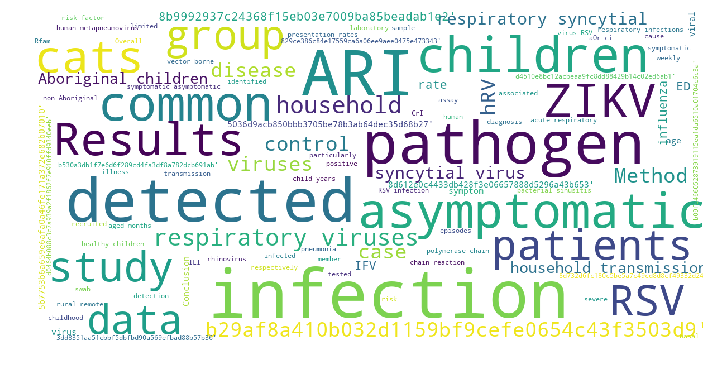

In [33]:
paper_lines = create_paper_lines(suggested_papers)
show_wordcloud(paper_lines)  ### Show the wordcloud for the given topic, what words are prevlant

In [34]:
id_paper_line_paper_id = create_mapping(paper_lines)  
bm25_task = create_paper_lines_index(paper_lines)
top_lines_suggestor(task1, bm25_task, id_paper_line_paper_id) ### Print the top lines in the potential papers

Paper line: A cohort of 47 households (493 individuals) in coastal Kenya was recruited and followed for a 26-week period spanning a complete RSV season. Nasopharyngeal swab specimens were requested weekly, during the first 4 weeks, and twice weekly thereafter from all household members, regardless of illness status.
Paper id: 5b7753b6a659e6afa0a46fe171a372e682b07010
Similarity Score: 171.8314415462581
-----
Paper line: Methods. A cohort of 47 households (493 individuals) in coastal Kenya was recruited and followed for a 26-week period spanning a complete RSV season.
Paper id: 5b7753b6a659e6afa0a46fe171a372e682b07010
Similarity Score: 142.25281191889027
-----
Paper line: Factors independently associated with an increased risk of asymptomatic RSV infection episodes were higher age, shorter duration of infection, bigger household size, lower peak viral load, absence of concurrent RSV infections within the household, infection by RSV group B, and no prior human rhinovirus infections. The p

### Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).


In [35]:
task3 = 'Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).'
suggested_papers, suggested_papers_dict = suggestPapers(task3)  ### TOP SUGGESTED PAPERS

Paper Id: 3677789674e47d9e9b35f87c659430e5295370e9
Title: Human Coronavirus 229E Remains Infectious on Common Touch Surface Materials
-----
Paper Id: ff6d57f2aad99be129432058665b361dc18747e8
Title: Brief Definitive Report MACROPHAGES GENETICALLY RESISTANT TO MOUSE HEPATITIS VIRUS CONVERTED IN VITRO TO SUSCEPTIBLE MACROPHAGES*
-----
Paper Id: 014e31dce7e3f2b1a7020a5debfbf228182f8b5e
Title: PROTECTION PERFORMANCE OF BIOLOGICAL PPE 521 Performance of materials used for biological personal protective equipment against blood splash penetration
-----
Paper Id: 1e5d47af3cdfd8ce02f55653005d7c8b75017e91
Title: trans-Golgl Retention of a Plasma Membrane Protein: Mutations in the Cytoplasmic Domain of the Asialoglycoprotein Receptor Subunit H1 Result in trans-Golgl Retention
-----
Paper Id: f37e28d5d912f4361695c361f5400b0045b88005
Title: Persistence in Temporary Lung Niches: A Survival Strategy of Lung-Resident Memory CD8 + T Cells
-----


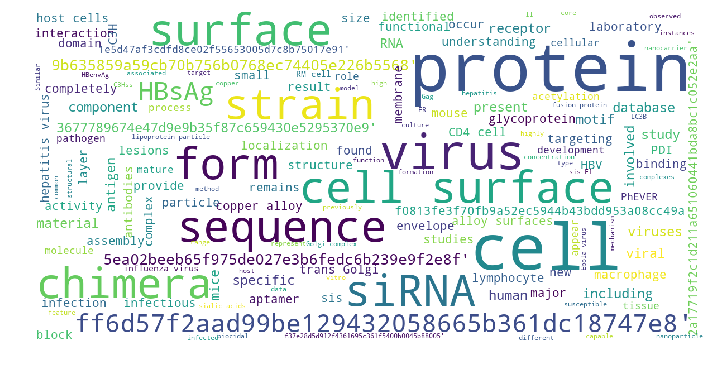

In [36]:
paper_lines = create_paper_lines(suggested_papers)
show_wordcloud(paper_lines)  ### Show the wordcloud for the given topic, what words are prevlant

In [37]:
id_paper_line_paper_id = create_mapping(paper_lines)  
bm25_task = create_paper_lines_index(paper_lines)
top_lines_suggestor(task3, bm25_task, id_paper_line_paper_id) ### Print the top lines in the potential papers

Paper line: We report here that pathogenic human coronavirus 229E remained infectious in a human lung cell culture model following at least 5 days of persistence on a range of common nonbiocidal surface materials, including polytetrafluoroethylene (Teflon; PTFE), polyvinyl chloride (PVC), ceramic tiles, glass, silicone rubber, and stainless steel. We have shown previously that noroviruses are destroyed on copper alloy surfaces.
Paper id: 3677789674e47d9e9b35f87c659430e5295370e9
Similarity Score: 430.2924499717585
-----
Paper line: Enveloped viruses are often susceptible to environmental stresses, but the human coronaviruses responsible for severe acute respiratory syndrome (SARS) and Middle East respiratory syndrome (MERS) have recently caused increasing concern of contact transmission during outbreaks. We report here that pathogenic human coronavirus 229E remained infectious in a human lung cell culture model following at least 5 days of persistence on a range of common nonbiocidal su

### Immune response and immunity

In [38]:
task4 = 'Immune response and immunity'
suggested_papers, suggested_papers_dict = suggestPapers(task4)  ### TOP SUGGESTED PAPER4

Paper Id: 998472a6428c367f65d047147899c5583db27ea2
Title: Table S1. Immune and/or Host Defense Functions of single nucleotide polymorphisms associated with depression based on meta-analyses of genome-wide association (GWAS) studies
-----
Paper Id: 7307753da247144e66cc91b8f48c33e5a9ceff2b
Title: Immune protection conferred by three commonly used commercial live attenuated vaccines against the prevalent local strains of avian infectious bronchitis virus in southern China
-----
Paper Id: c761570812ca07ce01397ebabc220556f51e786e
Title: Private specificities of CD8 T cell responses control patterns of heterologous immunity
-----
Paper Id: 05a12a1fb4a86a4158ad027b911092cfc25bc40b
Title: Nanoparticle Vaccines Adopting Virus-like Features for Enhanced Immune Potentiation
-----
Paper Id: 3c3a1e707eaf3efae5ae22cced7d4850ffc1f587
Title: Systems Biology-Based Platforms to Accelerate Research of Emerging Infectious Diseases
-----


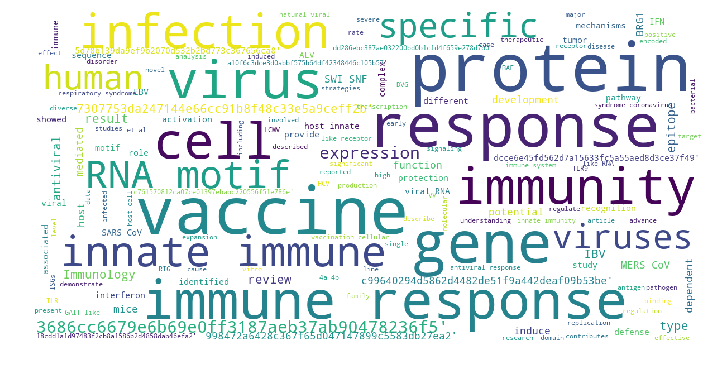

In [39]:
paper_lines = create_paper_lines(suggested_papers)
show_wordcloud(paper_lines)  ### Show the wordcloud for the given topic, what words are prevlant

In [40]:
id_paper_line_paper_id = create_mapping(paper_lines)  
bm25_task = create_paper_lines_index(paper_lines)
top_lines_suggestor(task4, bm25_task, id_paper_line_paper_id) ### Print the top lines in the potential papers

Paper line: Meta-analysis of genome-wide association data of bipolar disorder and major depressive disorder. Mol Psychiatry 2011; 16: 2-6 (a)
Gene Name Immune Function of Gene CACNA1C calcium channel, voltage-dependent, L type, alpha 1C subunit See article text for a discussion of immune and host defense functions of CACNA1C McMahon et al.
Paper id: 998472a6428c367f65d047147899c5583db27ea2
Similarity Score: 32.00026219016263
-----
Paper line: Mol Psychiatry 2011; 16: 2-6 (a)
Gene Name Immune Function of Gene CACNA1C calcium channel, voltage-dependent, L type, alpha 1C subunit See article text for a discussion of immune and host defense functions of CACNA1C McMahon et al. Meta-analysis of genome-wide association data identifies a risk locus for major mood disorders on 3p21.1.
Paper id: 998472a6428c367f65d047147899c5583db27ea2
Similarity Score: 31.076566578547386
-----
Paper line: Meta-analysis of genome-wide association data identifies a risk locus for major mood disorders on 3p21.1. Na

### Natural history of the virus and shedding of it from an infected person**

In [41]:
task5 = 'Natural history of the virus and shedding of it from an infected person'
suggested_papers, suggested_papers_dict = suggestPapers(task5)  ### TOP SUGGESTED PAPER4

Paper Id: 3c9f18f46f3aef0543e0e61213dd187af135f87b
Title: Influence of age and body condition on astrovirus infection of bats in Singapore: An evolutionary and epidemiological analysis
-----
Paper Id: b05c7d68086daf67e216e3df0ae0477343632d03
Title: Influence of age and body condition on astrovirus infection of bats in Singapore: An evolutionary and epidemiological analysis
-----
Paper Id: 7a5d731cd59597da7bcef171af936c0af4d7528c
Title: EPIDEMIC AND CASE INVESTIGATIONS Surveillance operation for the 141st confirmed case of Middle East Respiratory Syndrome coronavirus in response to the patient's prior travel to Jeju Island
-----
Paper Id: 148a0ab3b9bb851a56bbe926abed11c0d71fc61c
Title: Influence of Breed Size, Age, Fecal Quality, and Enteropathogen Shedding on Fecal Calprotectin and Immunoglobulin A Concentrations in Puppies During the Weaning Period
-----
Paper Id: 27d6ec2664104ba3347a3991ce63d20ebae32d39
Title: Isolation of Middle East Respiratory Syndrome Coronavirus from a Patient o

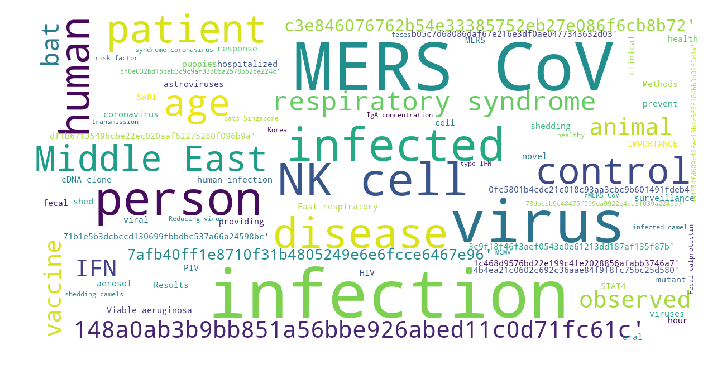

In [42]:
paper_lines = create_paper_lines(suggested_papers)
show_wordcloud(paper_lines)  ### Show the wordcloud for the given topic, what words are prevlant

In [43]:
id_paper_line_paper_id = create_mapping(paper_lines)  
bm25_task = create_paper_lines_index(paper_lines)
top_lines_suggestor(task5, bm25_task, id_paper_line_paper_id) ### Print the top lines in the potential papers

Paper line: Astroviruses, transmitted fecal-orally, are commonly detected in a wide diversity of bat species, are prevalent at high rates and are not thought to directly infect humans. These features make astroviruses useful in examining virus evolutionary history, epidemiology in the host, and temporal shedding trends.
Paper id: b05c7d68086daf67e216e3df0ae0477343632d03
Similarity Score: 72.94066209896921
-----
Paper line: Astroviruses, transmitted fecal-orally, are commonly detected in a wide diversity of bat species, are prevalent at high rates and are not thought to directly infect humans. These features make astroviruses useful in examining virus evolutionary history, epidemiology in the host, and temporal shedding trends.
Paper id: 3c9f18f46f3aef0543e0e61213dd187af135f87b
Similarity Score: 72.94066209896921
-----
Paper line: During the active surveillance, none of the 56 persons in self-isolation and 123 persons under active monitoring became infected. This fact supports that MERS